In [1]:
import numpy as np
import pandas as pd
import uuid
import json
import os
import urllib
# Install Packages
!pip install pdfminer.six

# Summary Statistics and Incomes for Taxes

### Downloading .pdf and .txt Tax Data

Here we download the tax data, released in PDFs. We then convert them to text, then parse through them and reconstruct taxable incomes. 

In [2]:
# TODO: is the data hidden on URLs that we don't know? 
# Is there more tax data uploaded that the government keeps on secret URLs?
# To Search Website Directory 
# Run: lftp URL
# Run: du -a > manifest.txt

Add the new data as necessary (format the name in a similar way to what exists, then put the link to the PDF)

In [3]:
tax_links = {
    "2013_ParliamentarianTax": "http://www.fbr.gov.pk/Downloads/Document/3769/1",
    "2014_ParliamentarianTax": "http://www.fbr.gov.pk/Downloads/Document/4122/1",
    "2015_ParliamentarianTax": "http://www.fbr.gov.pk/Downloads/Document/14688/1",
    "2016_ParliamentarianTax": "http://www.fbr.gov.pk/Downloads/Document/24994/1",
    "2017_ParliamentarianTax": "http://www.fbr.gov.pk/Downloads/Document/25724/1",
    "2013_Tax": "http://www.fbr.gov.pk/Downloads/Document/3808/1",
    "2014_Tax": "http://www.fbr.gov.pk/Downloads/Document/4124/1",
    "2015_Tax": "http://www.fbr.gov.pk/Downloads/Document/14689/1",
    "2016_Tax": "http://www.fbr.gov.pk/Downloads/Document/25006/1",
    "2017_Tax": "http://www.fbr.gov.pk/Downloads/Document/25725/1"
}

This next step creates a folder called "taxpayerData" at the location of this file. It then downloads all the above PDF files that are not already in that folder. This is safe to run if you have all the files above already downloaded and in the "taxpayerData" folder. It takes awhile (20,000 pages is around 10 minutes).

In [4]:
# Download Tax Data - takes awhile
folder_name = "taxpayerData"
if not os.path.exists("./" + folder_name + "/"):
    os.makedirs("./" + folder_name + "/")
    
for k in tax_links.keys():
    if os.path.exists("./" + folder_name + "/" + k + ".pdf"):
        continue
    link = tax_links[k]
    response = urllib.request.urlopen(str(link))
    with open("./" + folder_name + "/" + k + ".pdf", 'wb') as f:
        f.write(response.read())
    print("file uploaded:", k)

Now we convert these PDFs into text. Create a folder called "txtCreateFolder" inside taxpayerData. Drag any PDFs that you need to convert to text inside the folder. We will now run the below script to bulk convert the PDFs to text. 

This takes the longest time, DO NOT RUN if text file is already there.

In [2]:
# Tranform to text
!"./tools/convertmyfiles.sh"

Processing ./taxpayerData/txtCreateFolder/2017_ParliamentarianTax.pdf file...


In [6]:
###########################################################################
## Old code - change parser below                                        ##
## !python "./tools/pdf2txt.py" "./taxpayerData/2017_Tax.pdf" > test.txt ##
###########################################################################

### Constructing Taxable Income Lists

Now we'll parse through the taxpayer data, creating lists with taxpayers' taxable income.

In [7]:
# helper functions for
def is_comma_separated_number(line):
    if "," in line:
        potential_nums = line.split(",")
        for num in potential_nums:
            if not num.isdigit():
                return False
        return True
    else:
        return False
    
def three_digit_or_less_number(line):
    if len(line) <= 3 and len(line) >= 1 and line.isdigit():
        return True
    
    
def calculate_taxable_income(tax_paid):
    if tax_paid < 2000:
        amount_above_threshold = tax_paid / 0.02
        return 400000 + amount_above_threshold
    elif tax_paid < 14500:
        amount_above_threshold = (tax_paid - 2000) / 0.05
        return 500000 + amount_above_threshold
    elif tax_paid < 79500:
        amount_above_threshold = (tax_paid - 14500) / 0.10
        return 750000 + amount_above_threshold
    elif tax_paid < 92000:
        amount_above_threshold = (tax_paid - 79500) / 0.125
        return 1400000 + amount_above_threshold
    elif tax_paid < 137000:
        amount_above_threshold = (tax_paid - 92000) / 0.15
        return 1500000 + amount_above_threshold
    elif tax_paid < 259500:
        amount_above_threshold = (tax_paid - 137000) / 0.175
        return 1800000 + amount_above_threshold
    elif tax_paid < 359500:
        amount_above_threshold = (tax_paid - 259500) / 0.20
        return 2500000 + amount_above_threshold
    elif tax_paid < 472000:
        amount_above_threshold = (tax_paid - 359500) / 0.225
        return 3000000 + amount_above_threshold
    elif tax_paid < 597000:
        amount_above_threshold = (tax_paid - 472000) / 0.25
        return 3500000 + amount_above_threshold
    elif tax_paid < 1422000:
        amount_above_threshold = (tax_paid - 597000) / 0.275
        return 4000000 + amount_above_threshold
    elif tax_paid >= 1422000:
        amount_above_threshold = (tax_paid - 1422000) / 0.30
        return 7000000 + amount_above_threshold

In [34]:
# Salaried Individuals - 2016 - June 2017 Tax Year
f = open('./taxpayerData/2017_Tax.txt', 'r')

in_individuals_section = False
in_CNIC_section = False

taxes_paid = []
taxable_incomes = []
CNICs = set()
filers_that_didnt_pay = 0

print_number = 0
for line in f:
    if "INDIVIDUALS" in line:
        in_individuals_section = True
        continue
        
    # INDIVIDUALS SECTION
    if in_individuals_section:
        # Collect CNIC Number   
        line = line.strip()
        if line.isdigit() and len(line) > 3:
            CNICs.add(line)
        # Get Taxable Income
        elif "-" == line:
            filers_that_didnt_pay += 1
            print_number += 1
        elif is_comma_separated_number(line) or three_digit_or_less_number(line):
            tax_paid = int(line.replace(',', ''))
            taxes_paid.append(tax_paid)
            taxable_income = calculate_taxable_income(tax_paid)
            taxable_incomes.append(taxable_income)
            print_number += 1
            if print_number % 5000 == 0:
                print("%.2f%%" % ((len(taxable_incomes) + filers_that_didnt_pay)  * 100 / 1680405))
        else:
            continue

0.60%
1.19%
1.79%
2.38%
2.98%
3.57%
4.17%
4.76%
5.36%
5.95%
6.55%
7.14%
7.74%
8.33%
8.93%
9.22%
9.52%
10.12%
10.71%
11.31%
11.90%
12.50%
13.09%
13.69%
14.28%
14.88%
15.47%
16.07%
16.66%
17.26%
17.85%
18.45%
18.75%
19.04%
19.64%
20.23%
20.83%
21.42%
22.02%
22.61%
23.21%
23.51%
23.80%
24.40%
24.99%
25.59%
26.18%
26.78%
27.37%
27.67%
27.97%
28.56%
29.16%
29.75%
30.35%
30.94%
31.54%
32.14%
32.73%
33.33%
33.92%
34.22%
34.52%
35.11%
35.71%
36.30%
36.90%
37.49%
38.09%
38.68%
39.57%
39.87%
40.47%
41.06%
41.36%
41.66%
42.25%
42.85%
43.44%
44.04%
44.63%
45.23%
45.82%
46.42%
47.01%
47.31%
47.61%
48.20%
48.80%
49.39%
49.99%
50.58%
51.18%
51.77%
52.37%
52.96%
53.56%
54.15%
54.75%
55.34%
55.94%
56.53%
57.13%
57.43%
57.72%
58.32%
58.91%
59.21%
59.51%
60.10%
60.70%
61.29%
61.59%
61.89%
62.48%
62.78%
63.38%
63.97%
64.57%
65.16%
65.46%
65.76%
66.35%
66.95%
67.54%
68.14%
68.73%
69.03%
69.92%
70.22%
70.52%
71.11%
71.41%
71.71%
72.30%
72.90%
73.20%
73.49%
74.09%
74.68%
75.28%
75.87%
76.47%
77.06%
77.66%
78

In [35]:
# Sanity Check, how many entries are we missing?
print(1680405 - len(taxable_incomes) - filers_that_didnt_pay)

1


In [36]:
# Sanity Check, how many CNICs are we missing?
print(1680405 - len(CNICs))

1


In [37]:
# Percent of Filers EXCLUDING PARLIMENTARIANS who did not pay
print("%.2f%%" % (filers_that_didnt_pay  * 100 / 1680405))

35.28%


In [38]:
# Percent of Filers EXCLUDING PARLIMENTARIANS who did pay
print("%.2f%%" % (len(taxable_incomes) * 100 / 1680405))

64.72%


In [39]:
# Percent of National Income EXCLUDING PARLIMENTARIANS accounted for in Taxes
pni_excluding_parlimentarians = ((sum(taxable_incomes)) / 28476922920960) * 100
print(pni_excluding_parlimentarians)

6.713803027442684


#### Parlimentarian Tax

***UPDATE***: the parlimentarians are included in the general tax statement. This is unnecessary unless we want to know specific summary statistics about parlimentarians' taxable income.

Now let's add individual taxes paid by parlimentarians. To get the right format, we use Tabula (run the app found in the tools folder) to select the table in the pdf that we want to extract. We export the data to csv, open it in excel, manually remove the rows with "XXXX ASSEMBLY", save it as an .xlsx file, and then run the below script with the appropriate filename and path. 

Be sure that only the first row has the column names.

In [40]:
# Parlimentarians; 2016 - June 2017 Tax Year
parliamentarian_tax = pd.read_excel("./taxpayerData/2017_ParliamentarianTax.xlsx")

In [41]:
# parliamentarian_tax[parliamentarian_tax["Tax Paid"] == "-"]
parliamentarian_tax.head()

,Constituency,Name,CNIC,Tax Paid,Total Tax Paid by AOPs in which Taxpayer is a Member
0,BALOCHISTAN,ADVOCATE MUHAMMAD DAUD KHAN ACHAKZAI,5420210962027,424873,-
1,BALOCHISTAN,ASHOK KUMAR,4230183529279,2609406,-
2,BALOCHISTAN,GUL BASHRA,5650203511074,138573,-
3,BALOCHISTAN,HAFIZ HAMDULLAH,5420148513947,154313,-
4,BALOCHISTAN,JEHAN ZEB JAMALDINI,5410296067221,174909,-


In [42]:
p_not_in_general = 0
p_taxes_paid = parliamentarian_tax["Tax Paid"]
p_CNICs = parliamentarian_tax["CNIC"]
for i in range(0, parliamentarian_tax.shape[0]):
    p_tax_paid = p_taxes_paid[i]
    p_CNIC = p_CNICs[i]
    if str(p_CNIC) not in CNICs:
        p_not_in_general += 1
        if "-" == str(p_tax_paid):
            filers_that_didnt_pay += 1
        else:
            p_tax_paid = int(p_tax_paid)
            taxable_income = calculate_taxable_income(p_tax_paid)
            taxable_incomes.append(taxable_income)


p_no_taxes = 0
p_no_taxes_information = []
p_taxable_incomes = []
for i in range(0, parliamentarian_tax.shape[0]):
    p_tax_paid = p_taxes_paid[i]
    p_CNIC = p_CNICs[i]
    if "-" == str(p_tax_paid):
        p_no_taxes += 1
        name = parliamentarian_tax["Name"][i]
        cnic = parliamentarian_tax["CNIC"][i]
        constituency = parliamentarian_tax["Constituency"][i]
        p_no_taxes_information.append([name, cnic, constituency])
    else:
        p_tax_paid = int(p_tax_paid)
        taxable_income = calculate_taxable_income(p_tax_paid)
        p_taxable_incomes.append(taxable_income)

In [43]:
# Parliamentarians Not Included In General Tax Document
print(p_not_in_general)

0


In [44]:
# Parlimentarian Information (those who did NOT pay)
for p in p_no_taxes_information:
    print(p)

['NAJAF ABBAS SIAL', 3520193341681, 'NA-91']
['RANA MUHAMMAD QASIM NOON', 3520153766519, 'NA-153']
['MAKHDOOMZADA SYED BASIT AHMAD SULTAN BUKHARI', 3230250842007, 'NA-179']
['BEGUM TAHIRA BUKHARI', 1730114033692, 'KPK-7']
['SANTOSH KUMAR', 5510173810847, 'NM-63']
['SARDAR FAREED', 6110188026201, 'PK-45']
['SALEH MUHAMMAD', 7150113028525, 'PK-55']
['SYED GHULAM SHAH JEELANI', 4200090228787, 'PS-75']
['OWAIS MUZAFFAR', 4200044391775, 'PS-88']


In [45]:
# Percent of National Income provided exclusively by Parlimentarians
print((sum(p_taxable_incomes)* 100) / 28476922920960)

0.015456667769436777


In [46]:
# Percent of Filers who did not pay
print("%.2f%%" % (filers_that_didnt_pay  * 100 / 1680405))

35.28%


In [47]:
# Percent of Filers who did pay
print("%.2f%%" % (len(taxable_incomes) * 100 / 1680405))

64.72%


In [48]:
# Percent of Parlimentarians who did NOT pay
print("%.2f%%" % (p_no_taxes * 100 / parliamentarian_tax.shape[0]))

0.84%


In [49]:
# Percent of National Income accounted for in Taxes
pni = ((sum(taxable_incomes) / 0.95) / 28476922920960) * 100
print(pni)

7.067161081518616


In [50]:
# Percent of working-age population
(len(taxable_incomes) / 131000000) * 100

0.8301419847328245

In [102]:
sum(taxes_paid)

264696576322

In [52]:
import matplotlib.pyplot as plt

In [85]:
s_data = np.array(sorted(taxes_paid))
n = len(s_data)
percentiles = 100 * (np.arange(1, n+1) - 0.5) / n

In [86]:
x = 0.274 * sum(s_data)

In [87]:
i = 0
while x > 0:
    x = x - s_data[n - 1 - i]
    i += 1
i

2714

In [91]:
2714 / len(s_data) * 100

0.24956643120003383

In [96]:
s_data[n-10000]

3869682

In [99]:
export_data = sorted(taxable_incomes)
n = len(export_data)
t_percentiles = 100 * (np.arange(1, n+1) - 0.5) / n

In [100]:
%store export_data
%store t_percentiles

Stored 'export_data' (list)
Stored 't_percentiles' (ndarray)


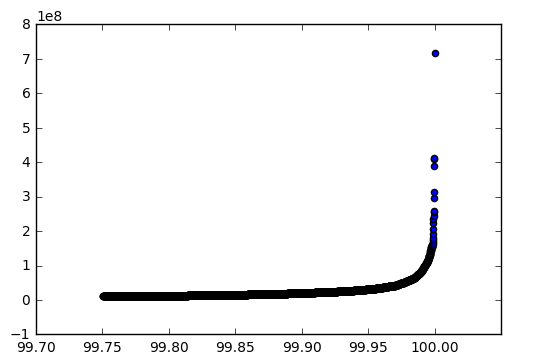

In [93]:
plt.scatter(percentiles[n-2714:], s_data[n-2714:])
plt.show()

In [64]:
s_data[n-10000]

3869682

## Assumptions
Full Zakat Deduction Taken for Each Taxpayer Who Paid

Donation Deduction

Medical deductions, zakat deductions, donations are huge (up to 30% of taxable income to nonprofit), interst / insurance premiums / investments, donations to pakistan dam fund

oil exploration and production sector are exempt from tax for a period of three years from the date of their arrival in Pakistan.

Also this is TAXABLE INCOME not total income. What are deductions, what is taxable income? Association of Persons and Companies not accounted for either.

What's the mode? this tell us where the bunching occurs...

# Exploratory Data Analysis